# MICOM analysis

In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os
import yaml

import pandas as pd

import micom
from micom import Community, load_pickle

from biofoundry.data.amils2023 import Amils2023DataLoader
from biofoundry.micom import (
    MICOMPreloader,
    MICOMMediumManager,
    plot_abundances_depth,
    plot_minimal_medium
)
from biofoundry.utils import save_fig

In [3]:
def save_sol(
    sol: micom.solution.CommunitySolution,
    path: str
) -> None:
    sol_df = sol.members.copy()
    sol_df["community_growth_rate"] = sol.growth_rate
    sol_df["status"] = sol.status

    sol_df.to_csv(path)

In [4]:
# Load config

with open("../biofoundry/config.yml") as config_file:
    config = yaml.safe_load(config_file)

In [5]:
output_dir = os.path.join(
    config["paths"]["micom"],
    "amils2023"
)

data_loader = Amils2023DataLoader()
preloader = MICOMPreloader(config)

In [6]:
abundances_df = data_loader.get_abundances()
abundances_df

,genus,sample_id,abundance
0,Acidiphilium,BH10-103-Illumina,0.0
1,Aciditerrimonas,BH10-103-Illumina,0.0
2,Acidovorax,BH10-103-Illumina,0.0
3,Acinetobacter,BH10-103-Illumina,0.0
4,Actinobacillus,BH10-103-Illumina,0.0
...,...,...,...
1031,Spirosoma,BH10-496-Roche,0.0
1032,Truepera,BH10-496-Roche,0.0
1033,WPS-1_genera_incertae_sedis,BH10-496-Roche,0.0
1034,Xylanimicrobium,BH10-496-Roche,0.0


In [7]:
metadata_df = pd.read_csv(
    os.path.join(
        config["paths"]["genomes"],
        "genomes-metadata.csv"
    )
)

taxonomy_df = preloader.get_taxonomy(metadata_df)
taxonomy_df

,id,genus,species,reactions,metabolites,file
0,aci,Acidovorax,Acidovorax BoFeN1,1246,1199,../data/gem/aci_formatted.json
1,bme,Brevundimonas,Brevundimonas sp. T2.26MG-97,431,460,../data/gem/bme_formatted.json
2,dmi,Desulfosporosinus,Desulfosporosinus meridiei DEEP,1157,1104,../data/gem/dmi_formatted.json
3,pse,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json
4,rhi1,Rhizobium,Rhizobium sp. T2.30D-1.1,712,797,../data/gem/rhi1_formatted.json
5,rhi2,Rhizobium,Rhizobium sp. T2.26MG-112.2,683,773,../data/gem/rhi2_formatted.json
6,rho,Rhodoplanes,Rhodoplanes sp. T2.26MG-98,442,490,../data/gem/rho_formatted.json
7,shw,Shewanella,Shewanella sp. T2.3D-1.1,1324,1193,../data/gem/shw_formatted.json
8,tel,Tessaracoccus,Tessaracoccus lapidicaptus IPBSL-7,1199,1111,../data/gem/tel_formatted.json
9,tez,Tessaracoccus,Tessaracoccus sp. T2.5-30,1197,1114,../data/gem/tez_formatted.json


### Combining taxonomy and abundances

In [8]:
taxonomy_abundances = pd.merge(
    left=taxonomy_df,
    right=abundances_df,
    on="genus",
    how="left"
)

# Combine ID column with sample ID to avoid errors in MICOM due to ID duplicates
taxonomy_abundances["id"] = \
    taxonomy_abundances["id"] + "_" + taxonomy_abundances["sample_id"]

# Replace characters not allowed in MICOM
taxonomy_abundances["id"] = taxonomy_abundances["id"].str.replace("-", "_")

print(
    "[WARNING] Species for which there are no abundance data:\n",
    taxonomy_abundances[taxonomy_abundances["id"].isnull()]["species"].values
)

# Save to file
taxonomy_abundances.to_csv(
    os.path.join(
        output_dir,
        "taxonomy.csv"
    ),
    header=True,
    index=False,
    sep=","
)

[WARNING] Species for which there are no abundance data:
 ['Brevundimonas sp. T2.26MG-97' 'Desulfosporosinus meridiei DEEP'
 'Rhodoplanes sp. T2.26MG-98' 'Shewanella sp. T2.3D-1.1']


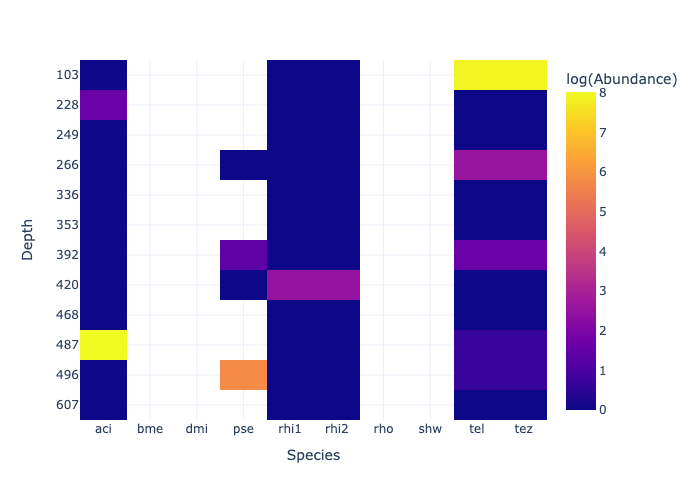

In [9]:
fig = plot_abundances_depth(
    taxonomy_df=taxonomy_abundances,
    config=config
)
fig.show("png")

save_fig(
    fig=fig,
    filename="amils2023-abundances-depth.jpg",
    config=config
)

In [10]:
# WARNING: only Pseudomonas is found in Roche samples
taxonomy_abundances[
    taxonomy_abundances["sample_id"].str.contains("Roche", na=False)
]

,id,genus,species,reactions,metabolites,file,sample_id,abundance,Code,Depth,log_abundance
14,pse_BH10_266_Roche,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,BH10-266-Roche,0.0,pse,266,0.000000
15,pse_BH10_392_Roche,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,BH10-392-Roche,3.0,pse,392,1.386294
16,pse_BH10_420_Roche,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,BH10-420-Roche,0.0,pse,420,0.000000
17,pse_BH10_496_Roche,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,BH10-496-Roche,320.0,pse,496,5.771441


In [11]:
%%script false --no-raise-error

# Build community
com = Community(taxonomy_abundances)

# Save community
com.to_pickle(
    os.path.join(
        output_dir,
        "paper_abundances",
        "community.pickle"
    )
)

In [12]:
%%script false --no-raise-error

# Get tradeoffs
sol = com.cooperative_tradeoff()

## Experiments

In [13]:
GROWTH_FRACTION = 0.75
GROWTH_TOLERANCE = 0.75
MIN_GROWTH = 0.1

### 1. Same abundance among species

1.0. Minimal medium

1.1. Objective: community growth

1.2. Objective: production of metabolite of interest

1.3. Objective: community growth + production of metabolite of interest

1.4. Objective: community growth + production of metabolite of interest + anaerobic conditions

In [14]:
# Create new dataframe with just one sample and equal abundances
taxonomy_abundances_equal = taxonomy_abundances.copy()

# Format for dropping duplicates
taxonomy_abundances_equal["id"] = taxonomy_abundances_equal["Code"].copy()
taxonomy_abundances_equal["sample_id"] = "sample_id"
taxonomy_abundances_equal["abundance"] = 1.0
taxonomy_abundances_equal = taxonomy_abundances_equal\
    .drop(["Code", "Depth", "log_abundance"], axis=1)

# Finally, drop duplicates
taxonomy_abundances_equal = taxonomy_abundances_equal\
    .drop_duplicates()\
    .reset_index(drop=True)

taxonomy_abundances_equal

,id,genus,species,reactions,metabolites,file,sample_id,abundance
0,aci,Acidovorax,Acidovorax BoFeN1,1246,1199,../data/gem/aci_formatted.json,sample_id,1.0
1,bme,Brevundimonas,Brevundimonas sp. T2.26MG-97,431,460,../data/gem/bme_formatted.json,sample_id,1.0
2,dmi,Desulfosporosinus,Desulfosporosinus meridiei DEEP,1157,1104,../data/gem/dmi_formatted.json,sample_id,1.0
3,pse,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,sample_id,1.0
4,rhi1,Rhizobium,Rhizobium sp. T2.30D-1.1,712,797,../data/gem/rhi1_formatted.json,sample_id,1.0
5,rhi2,Rhizobium,Rhizobium sp. T2.26MG-112.2,683,773,../data/gem/rhi2_formatted.json,sample_id,1.0
6,rho,Rhodoplanes,Rhodoplanes sp. T2.26MG-98,442,490,../data/gem/rho_formatted.json,sample_id,1.0
7,shw,Shewanella,Shewanella sp. T2.3D-1.1,1324,1193,../data/gem/shw_formatted.json,sample_id,1.0
8,tel,Tessaracoccus,Tessaracoccus lapidicaptus IPBSL-7,1199,1111,../data/gem/tel_formatted.json,sample_id,1.0
9,tez,Tessaracoccus,Tessaracoccus sp. T2.5-30,1197,1114,../data/gem/tez_formatted.json,sample_id,1.0


In [15]:
# Build community
com = Community(taxonomy_abundances_equal)

# Save community
equal_abundances_path = os.path.join(
    output_dir,
    "equal_abundances/"
    "community.pickle"
)
com.to_pickle(equal_abundances_path)

Output()

### 1.0. Minimal Medium

[20:54:41] WARNING  the MIP version of minimal media is extremely slow for models that large :(         ]8;id=307727;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/media.py\media.py]8;;\:]8;id=14243;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/media.py#72\72]8;;\

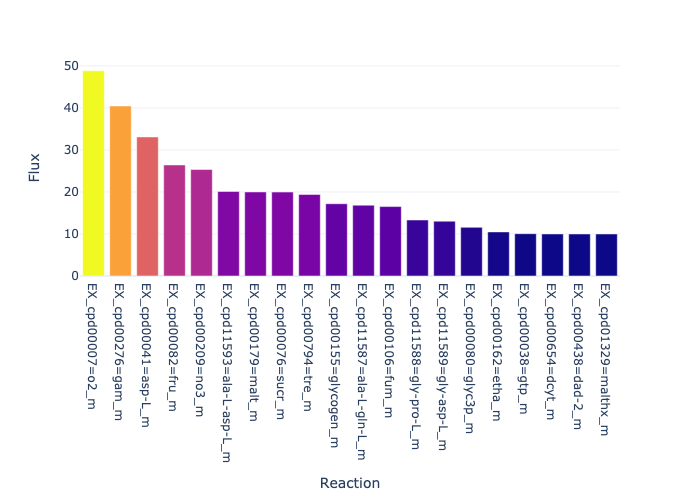

In [16]:
medium_manager = MICOMMediumManager(config)

min_medium = medium_manager.get_min_medium(
    com=com,
    growth_tolerance=MIN_GROWTH
)

fig = plot_minimal_medium(
    min_medium=min_medium,
    top_n=20,
    config=config
)
fig.show("png")

save_fig(
    fig=fig,
    filename="micom-limiting-metabolites.jpg",
    config=config
)

In [17]:
medium_df = data_loader.get_data()

# Get maximum concentration of all metabolites (upper bound)
medium_df = medium_df\
    .drop("Depth", axis=1)\
    .groupby("Species", as_index=False)\
    .max()

medium_df

,Species,Concentration (ppm)
0,Acetate,200.560000
1,Al,76191.550000
2,Ba,1888.470000
3,Bromine,1.123333
4,C,3745.500000
5,CH4,35.000000
6,CO2,2000.000000
7,Ca,59183.130000
8,Chlorine,59.345714
9,Co,726.170000


In [18]:
medium_adjusted = medium_manager.extrapolate_medium(
    medium_df=medium_df,
    min_medium=min_medium,
    shared_comp="Nitrate",
    shared_flux="EX_cpd00209=no3_m"
)

In [19]:
# TODO: check fix_medium

# from micom.workflows import fix_medium

# candidate_medium = pd.DataFrame.from_records([
#     {"reaction": "EX_glc__D_m", "flux": 10}
# ])
# candidate_medium

# medium = fix_medium(
#     manifest,
#     model_folder=MODEL_DIR,
#     medium=candidate_medium,
#     community_growth=0.1,
#     min_growth=0.01,
#     max_import=10,
#     threads=N_THREADS
# )
# medium

#### 1.1. Objective: community growth

In [20]:
# Load community
com = load_pickle(equal_abundances_path)

# Add medium
com.medium = medium_adjusted

# Get tradeoffs
sol = com.cooperative_tradeoff(
    min_growth=MIN_GROWTH,
    fraction=GROWTH_FRACTION,
    fluxes=False,
    pfba=False
)

save_sol(
    sol=sol,
    path=os.path.join(
        output_dir,
        "equal_abundances/"
        "growth_aerobic.csv"
    )
)

sol

[20:54:57] WARNING  I could not find the following exchanges in your model: EX_cpd19013=NH4-_m,    ]8;id=251781;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=610156;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py#669\669]8;;\
                    EX_cpd00180=oxa_m, EX_cpd27447=CH3_m, EX_cpd09695=Sr2-_m, EX_cpd30760=Cu-I-_m,                 
                    EX_cpd09693=Ba2-_m, EX_cpd00141=ppa_m, EX_cpd12853=P_m, EX_cpd20429=Cobalt_m,                  
                    EX_cpd24344=Al---_m, EX_cpd20864=Manganese-3--_m, EX_cpd11640=h2_m,                            
                    EX_cpd20862=Nickel-2--_m, EX_cpd11610=AH2_m, EX_cpd20863=Manganese-2--_m,                      
                    EX_cpd12856=C_m, EX_cpd22527=Co-I-_m, EX_cpd12855=Al_m, EX_cpd01024=metha_m,                   
                    EX_cpd00666=tartr-L_m, EX_cpd32662=Ti3-_m, EX_cpd17005=cobalt3_m,                              
                    EX_cpd32426=Ti2-_m, EX_cpd27025=Fe-4_m, EX_cpd00021=Iron_m, EX_cpd12854=Si_m                   

,abundance,growth_rate,reactions,metabolites
compartments,,,,
aci,0.1,31.087809,1246,1199
bme,0.1,2.247550,431,460
dmi,0.1,15.712006,1157,1104
medium,NaN,NaN,194,194
pse,0.1,31.066796,1461,1295
...,...,...,...,...
rhi2,0.1,2.215071,683,773
rho,0.1,2.309319,442,490
shw,0.1,31.071201,1324,1193


#### 1.2. Objective: community growth + anaerobic conditions

In [21]:
medium_adjusted_anaerobic = medium_adjusted.copy()
medium_adjusted_anaerobic["EX_cpd00007=o2_m"] = 0.0

In [22]:
# Load community
com = load_pickle(equal_abundances_path)

# Add medium
com.medium = medium_adjusted_anaerobic

# Get tradeoffs
sol = com.cooperative_tradeoff(
    min_growth=MIN_GROWTH,
    fraction=GROWTH_FRACTION,
    fluxes=False,
    pfba=False
)

save_sol(
    sol=sol,
    path=os.path.join(
        output_dir,
        "equal_abundances/"
        "growth_anaerobic.csv"
    )
)

sol

[20:55:15] WARNING  I could not find the following exchanges in your model: EX_cpd19013=NH4-_m,    ]8;id=573652;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=674285;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py#669\669]8;;\
                    EX_cpd00180=oxa_m, EX_cpd27447=CH3_m, EX_cpd09695=Sr2-_m, EX_cpd30760=Cu-I-_m,                 
                    EX_cpd09693=Ba2-_m, EX_cpd00141=ppa_m, EX_cpd12853=P_m, EX_cpd20429=Cobalt_m,                  
                    EX_cpd24344=Al---_m, EX_cpd20864=Manganese-3--_m, EX_cpd11640=h2_m,                            
                    EX_cpd20862=Nickel-2--_m, EX_cpd11610=AH2_m, EX_cpd20863=Manganese-2--_m,                      
                    EX_cpd12856=C_m, EX_cpd22527=Co-I-_m, EX_cpd12855=Al_m, EX_cpd01024=metha_m,                   
                    EX_cpd00666=tartr-L_m, EX_cpd32662=Ti3-_m, EX_cpd17005=cobalt3_m,                              
                    EX_cpd32426=Ti2-_m, EX_cpd27025=Fe-4_m, EX_cpd00021=Iron_m, EX_cpd12854=Si_m                   

,abundance,growth_rate,reactions,metabolites
compartments,,,,
aci,0.1,23.647867,1246,1199
bme,0.1,2.247417,431,460
dmi,0.1,15.631632,1157,1104
medium,NaN,NaN,194,194
pse,0.1,23.641518,1461,1295
...,...,...,...,...
rhi2,0.1,2.219551,683,773
rho,0.1,2.309186,442,490
shw,0.1,23.647652,1324,1193


#### 1.3. Objective: Production of metabolite of interest

In [23]:
# Get 3-hydroxybutyrate InChI (PubChem)
source_inchikey = "WHBMMWSBFZVSSR-UHFFFAOYSA-M"

modelseed_cpd = pd.read_table(
    os.path.join(
        config["paths"]["modelseed"],
        "compounds.tsv"
    ),
    dtype=object # Avoid warnings
)

# Not found by InChIKey
modelseed_cpd[modelseed_cpd["inchikey"] == source_inchikey]

,id,abbreviation,name,formula,mass,source,inchikey,charge,is_core,is_obsolete,...,is_cofactor,deltag,deltagerr,pka,pkb,abstract_compound,comprised_of,aliases,smiles,notes


In [24]:
source_matches = modelseed_cpd["aliases"].dropna(axis=0)\
    .str.findall("3-hydroxybutyrate")\
    .apply(",".join)

source_matches = source_matches[
    source_matches != ""
]

modelseed_cpd.iloc[source_matches.index]

,id,abbreviation,name,formula,mass,source,inchikey,charge,is_core,is_obsolete,...,is_cofactor,deltag,deltagerr,pka,pkb,abstract_compound,comprised_of,aliases,smiles,notes
782,cpd00797,bhb,(R)-3-Hydroxybutanoate,C4H7O3,103.0,Primary Database,WHBMMWSBFZVSSR-GSVOUGTGSA-M,-1,1,0,...,0,-55.56,0.53,1:5:4.41;1:7:15.70,1:7:-2.62,NaN,NaN,Name: (R)-3-Hydroxybutanoate; (R)-3-Hydroxybut...,C[C@@H](O)CC(=O)[O-],GC|EQ|EQU


In [25]:
# Get ModelSEED compound ID and abbreviation to retrieve its reactions in the 
# MICOM community
source_modelseed_id = modelseed_cpd.iloc[source_matches.index]\
    [["id", "abbreviation"]]

source_modelseed_id = \
    source_modelseed_id["id"] + "=" + source_modelseed_id["abbreviation"]

source_modelseed_id = source_modelseed_id.values[0]

# Get all possible combinations for the metabolites:
# ModelSEED ID + abbreviation + all compartments + all organisms
source_micom_ids = [
    f"{source_modelseed_id}_{compartment}"
    for compartment in com.compartments.keys()
]
source_micom_ids

['cpd00797=bhb_c__aci',
 'cpd00797=bhb_e__aci',
 'cpd00797=bhb_m',
 'cpd00797=bhb_c__bme',
 'cpd00797=bhb_e__bme',
 'cpd00797=bhb_c__dmi',
 'cpd00797=bhb_e__dmi',
 'cpd00797=bhb_c__pse',
 'cpd00797=bhb_e__pse',
 'cpd00797=bhb_c__rhi1',
 'cpd00797=bhb_e__rhi1',
 'cpd00797=bhb_c__rhi2',
 'cpd00797=bhb_e__rhi2',
 'cpd00797=bhb_c__rho',
 'cpd00797=bhb_e__rho',
 'cpd00797=bhb_c__shw',
 'cpd00797=bhb_e__shw',
 'cpd00797=bhb_c__tel',
 'cpd00797=bhb_e__tel',
 'cpd00797=bhb_c__tez',
 'cpd00797=bhb_e__tez']

In [26]:
source_reactions = []

for source_id in source_micom_ids:
    try:
        source_reactions += list(
            com.metabolites.get_by_id(source_id).reactions
        )
    except KeyError:
        print(f"[ERROR] ID not found! {source_id}")

# Remove potential duplicates
source_reactions = list(set(source_reactions))
source_reactions

[ERROR] ID not found! cpd00797=bhb_e__aci
[ERROR] ID not found! cpd00797=bhb_c__bme
[ERROR] ID not found! cpd00797=bhb_e__bme
[ERROR] ID not found! cpd00797=bhb_c__dmi
[ERROR] ID not found! cpd00797=bhb_e__dmi
[ERROR] ID not found! cpd00797=bhb_c__rhi1
[ERROR] ID not found! cpd00797=bhb_e__rhi1
[ERROR] ID not found! cpd00797=bhb_c__rhi2
[ERROR] ID not found! cpd00797=bhb_e__rhi2
[ERROR] ID not found! cpd00797=bhb_c__rho
[ERROR] ID not found! cpd00797=bhb_e__rho
[ERROR] ID not found! cpd00797=bhb_c__shw
[ERROR] ID not found! cpd00797=bhb_e__shw
[ERROR] ID not found! cpd00797=bhb_e__tel
[ERROR] ID not found! cpd00797=bhb_e__tez


[<Reaction EX_cpd00797=bhb_m at 0x1645f4c10>,
 <Reaction rxn00992_c__tel at 0x160c57040>,
 <Reaction rxn00038_c__aci at 0x16809a680>,
 <Reaction rxn00992_c__pse at 0x164eb2890>,
 <Reaction rxn12405_c__pse at 0x16561f0d0>,
 <Reaction rxn00992_c__tez at 0x166121930>,
 <Reaction EX_cpd00797=bhb_e__pse at 0x16481cb50>,
 <Reaction rxn00992_c__aci at 0x1684099c0>]

In [27]:
# Change upper bound for allowing production
# See: https://cobrapy-cdiener.readthedocs.io/en/latest/simulating.html#Changing-the-Objectives
for reaction in source_reactions:
    reaction.upper_bound = 5000.

    print(reaction.id, reaction.upper_bound)

EX_cpd00797=bhb_m 5000.0
rxn00992_c__tel 5000.0
rxn00038_c__aci 5000.0
rxn00992_c__pse 5000.0
rxn12405_c__pse 5000.0
rxn00992_c__tez 5000.0
EX_cpd00797=bhb_e__pse 5000.0
rxn00992_c__aci 5000.0


In [28]:
# Load community
com = load_pickle(equal_abundances_path)

# Add medium
com.medium = medium_adjusted

# Set as objective all reactions in which the target is found
com.objective = source_reactions

print("Objective:", com.objective.expression)

# Get tradeoffs
sol = com.cooperative_tradeoff(
    min_growth=MIN_GROWTH,
    fraction=GROWTH_FRACTION,
    fluxes=True,
    pfba=True
)

save_sol(
    sol=sol,
    path=os.path.join(
        output_dir,
        "equal_abundances/"
        "production.csv"
    )
)

sol

[20:55:28] WARNING  I could not find the following exchanges in your model: EX_cpd19013=NH4-_m,    ]8;id=784537;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=918904;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py#669\669]8;;\
                    EX_cpd00180=oxa_m, EX_cpd27447=CH3_m, EX_cpd09695=Sr2-_m, EX_cpd30760=Cu-I-_m,                 
                    EX_cpd09693=Ba2-_m, EX_cpd00141=ppa_m, EX_cpd12853=P_m, EX_cpd20429=Cobalt_m,                  
                    EX_cpd24344=Al---_m, EX_cpd20864=Manganese-3--_m, EX_cpd11640=h2_m,                            
                    EX_cpd20862=Nickel-2--_m, EX_cpd11610=AH2_m, EX_cpd20863=Manganese-2--_m,                      
                    EX_cpd12856=C_m, EX_cpd22527=Co-I-_m, EX_cpd12855=Al_m, EX_cpd01024=metha_m,                   
                    EX_cpd00666=tartr-L_m, EX_cpd32662=Ti3-_m, EX_cpd17005=cobalt3_m,                              
                    EX_cpd32426=Ti2-_m, EX_cpd27025=Fe-4_m, EX_cpd00021=Iron_m, EX_cpd12854=Si_m                   

Objective: 1.0*EX_cpd00797=bhb_e__pse - 1.0*EX_cpd00797=bhb_e__pse_reverse_cbc5d + 1.0*EX_cpd00797=bhb_m - 1.0*EX_cpd00797=bhb_m_reverse_6a492 + 1.0*rxn00038_c__aci - 1.0*rxn00038_c__aci_reverse_580dd + 1.0*rxn00992_c__aci - 1.0*rxn00992_c__aci_reverse_8442a + 1.0*rxn00992_c__pse - 1.0*rxn00992_c__pse_reverse_7a810 + 1.0*rxn00992_c__tel - 1.0*rxn00992_c__tel_reverse_c4952 + 1.0*rxn00992_c__tez - 1.0*rxn00992_c__tez_reverse_50d69 + 1.0*rxn12405_c__pse - 1.0*rxn12405_c__pse_reverse_8921e


,abundance,growth_rate,reactions,metabolites
compartments,,,,
aci,0.1,31.086527,1246,1199
bme,0.1,2.247568,431,460
dmi,0.1,15.622948,1157,1104
medium,NaN,NaN,194,194
pse,0.1,31.066647,1461,1295
...,...,...,...,...
rhi2,0.1,2.215262,683,773
rho,0.1,2.307545,442,490
shw,0.1,31.067190,1324,1193


In [29]:
source_fluxes = [
    reaction.id.split("__")[0]
    for reaction in source_reactions
]

sol.fluxes[source_fluxes]

reaction,EX_cpd00797=bhb_m,rxn00992_c,rxn00038_c,rxn00992_c,rxn12405_c,rxn00992_c,EX_cpd00797=bhb_e,rxn00992_c
compartment,,,,,,,,
aci,NaN,2.206323e-06,8.726758e-07,2.206323e-06,NaN,2.206323e-06,NaN,2.206323e-06
bme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medium,-0.078988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pse,NaN,7.898809e-01,NaN,7.898809e-01,0.789881,7.898809e-01,-0.789881,7.898809e-01
rhi1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rhi2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.4. Objective: community growth + production of metabolite of interest

Check [this issue](https://github.com/micom-dev/micom/discussions/21#discussioncomment-339032) for details.

In [30]:
from micom.util import _apply_min_growth


# Load community
com = load_pickle(equal_abundances_path)

# Add medium
com.medium = medium_adjusted

sol = com.cooperative_tradeoff(
    min_growth=MIN_GROWTH,
    fraction=GROWTH_FRACTION,
    fluxes=False,
    pfba=False
)

# Change upper bound for allowing production
# See: https://cobrapy-cdiener.readthedocs.io/en/latest/simulating.html#Changing-the-Objectives
for reaction in source_reactions:
    reaction.upper_bound = 5000.

with com:
    _apply_min_growth(com, sol.members.growth_rate.drop("medium"))
    com.objective = source_reactions
    ac_sol = com.optimize()

save_sol(
    sol=ac_sol,
    path=os.path.join(
        output_dir,
        "equal_abundances/"
        "growth_and_production_aerobic.csv"
    )
)

ac_sol

[20:56:26] WARNING  I could not find the following exchanges in your model: EX_cpd19013=NH4-_m,    ]8;id=553453;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=617842;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py#669\669]8;;\
                    EX_cpd00180=oxa_m, EX_cpd27447=CH3_m, EX_cpd09695=Sr2-_m, EX_cpd30760=Cu-I-_m,                 
                    EX_cpd09693=Ba2-_m, EX_cpd00141=ppa_m, EX_cpd12853=P_m, EX_cpd20429=Cobalt_m,                  
                    EX_cpd24344=Al---_m, EX_cpd20864=Manganese-3--_m, EX_cpd11640=h2_m,                            
                    EX_cpd20862=Nickel-2--_m, EX_cpd11610=AH2_m, EX_cpd20863=Manganese-2--_m,                      
                    EX_cpd12856=C_m, EX_cpd22527=Co-I-_m, EX_cpd12855=Al_m, EX_cpd01024=metha_m,                   
                    EX_cpd00666=tartr-L_m, EX_cpd32662=Ti3-_m, EX_cpd17005=cobalt3_m,                              
                    EX_cpd32426=Ti2-_m, EX_cpd27025=Fe-4_m, EX_cpd00021=Iron_m, EX_cpd12854=Si_m                   

,abundance,growth_rate,reactions,metabolites
compartments,,,,
aci,0.1,44.878562,1246,1199
bme,0.1,2.247552,431,460
dmi,0.1,15.738315,1157,1104
medium,NaN,NaN,194,194
pse,0.1,31.066851,1461,1295
...,...,...,...,...
rhi2,0.1,2.223560,683,773
rho,0.1,2.309304,442,490
shw,0.1,31.071164,1324,1193


#### 1.5. Objective: community growth + production of metabolite of interest + anaerobic conditions

See [this documentation page](https://cobrapy-cdiener.readthedocs.io/en/latest/media.html#Growth-media).

In [31]:
from micom.util import _apply_min_growth


# Load community
com = load_pickle(equal_abundances_path)

# Add medium
com.medium = medium_adjusted_anaerobic

sol = com.cooperative_tradeoff(
    min_growth=MIN_GROWTH,
    fraction=GROWTH_FRACTION,
    fluxes=False,
    pfba=False
)

# Change upper bound for allowing production
# See: https://cobrapy-cdiener.readthedocs.io/en/latest/simulating.html#Changing-the-Objectives
for reaction in source_reactions:
    reaction.upper_bound = 5000.

with com:
    _apply_min_growth(com, sol.members.growth_rate.drop("medium"))
    com.objective = source_reactions
    ac_sol = com.optimize()

save_sol(
    sol=ac_sol,
    path=os.path.join(
        output_dir,
        "equal_abundances/"
        "growth_and_production_anaerobic.csv"
    )
)

ac_sol

[20:57:24] WARNING  I could not find the following exchanges in your model: EX_cpd19013=NH4-_m,    ]8;id=614501;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=825641;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py#669\669]8;;\
                    EX_cpd00180=oxa_m, EX_cpd27447=CH3_m, EX_cpd09695=Sr2-_m, EX_cpd30760=Cu-I-_m,                 
                    EX_cpd09693=Ba2-_m, EX_cpd00141=ppa_m, EX_cpd12853=P_m, EX_cpd20429=Cobalt_m,                  
                    EX_cpd24344=Al---_m, EX_cpd20864=Manganese-3--_m, EX_cpd11640=h2_m,                            
                    EX_cpd20862=Nickel-2--_m, EX_cpd11610=AH2_m, EX_cpd20863=Manganese-2--_m,                      
                    EX_cpd12856=C_m, EX_cpd22527=Co-I-_m, EX_cpd12855=Al_m, EX_cpd01024=metha_m,                   
                    EX_cpd00666=tartr-L_m, EX_cpd32662=Ti3-_m, EX_cpd17005=cobalt3_m,                              
                    EX_cpd32426=Ti2-_m, EX_cpd27025=Fe-4_m, EX_cpd00021=Iron_m, EX_cpd12854=Si_m                   

,abundance,growth_rate,reactions,metabolites
compartments,,,,
aci,0.1,41.130346,1246,1199
bme,0.1,2.247550,431,460
dmi,0.1,15.701550,1157,1104
medium,NaN,NaN,194,194
pse,0.1,23.984587,1461,1295
...,...,...,...,...
rhi2,0.1,2.223719,683,773
rho,0.1,2.309342,442,490
shw,0.1,42.355336,1324,1193


## Visualization

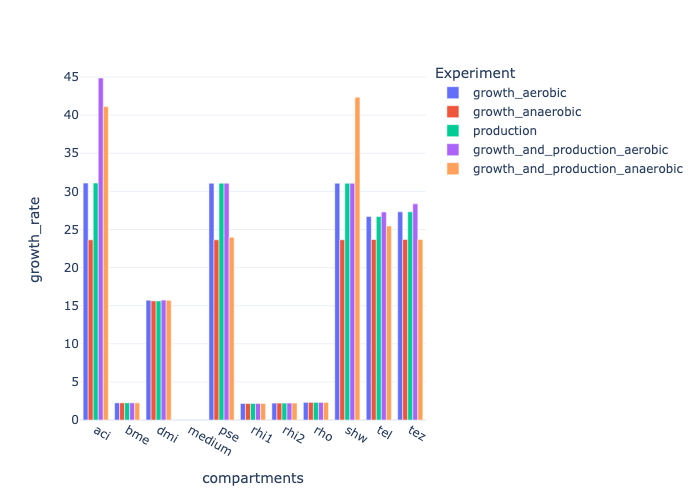

In [40]:
import glob

import plotly.express as px


glob_pattern = os.path.join(
    output_dir,
    "equal_abundances/*.csv"
)

plot_df = pd.DataFrame()

for filename in glob.glob(glob_pattern):

    file_df = pd.read_csv(filename)
    file_df["Experiment"] = os.path.splitext(os.path.basename(filename))[0]

    plot_df = pd.concat(
        [plot_df, file_df],
        axis=0,
        ignore_index=True
    )

fig = px.bar(
    data_frame=plot_df,
    x="compartments",
    y="growth_rate",
    color="Experiment",
    barmode="group",
    category_orders={
        "Experiment": [
            "growth_aerobic",
            "growth_anaerobic",
            "production",
            "growth_and_production_aerobic",
            "growth_and_production_anaerobic"
        ]
    },
    template=config["figures"]["template"]
)
fig.show("png")